In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as  plt
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.utils import Sequence
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, TimeDistributed, LSTM
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, SGD


In [ ]:
import os
import zipfile


from google.colab import drive
drive.mount('/content/drive')


zip_path = '/content/drive/MyDrive/Drowsiness Prediction Dataset.zip'


extract_path = '/content/drowsiness_dataset'
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)


data_dir = extract_path


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

data_dir = '/content/drowsiness_dataset'


datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)


train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='training',
    shuffle=True
)

validation_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='validation',
    shuffle=False
)

print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {validation_generator.samples}")


Found 7296 images belonging to 1 classes.
Found 1824 images belonging to 1 classes.
Training samples: 7296
Validation samples: 1824


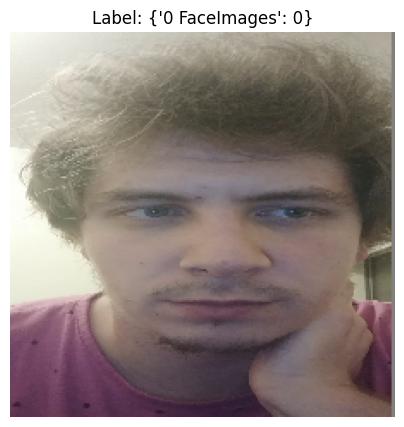

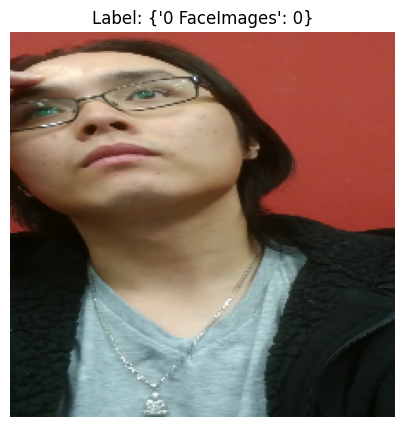

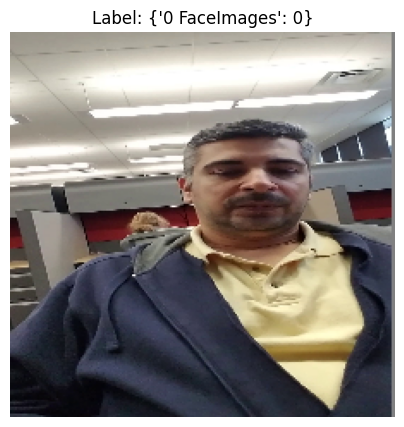

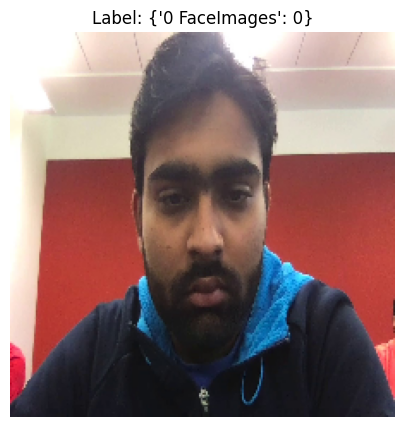

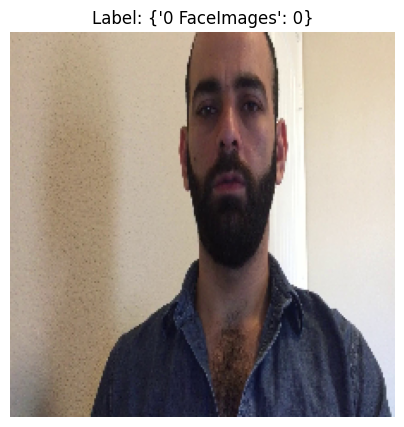

In [ ]:
num_images = 5

for i in range(num_images):
    image, label = next(train_generator)
    rand_index = np.random.randint(0, len(image))
    img = image[rand_index]
    label = label[rand_index]

    plt.figure(figsize=(5,5))
    plt.imshow(img)
    plt.title(f"Label: {train_generator.class_indices}")
    plt.axis('off')
    plt.show()

In [ ]:
from tensorflow.keras.layers import TimeDistributed, LSTM, GlobalAveragePooling2D, Reshape

seq_length = 3

model = Sequential([
    TimeDistributed(Conv2D(16, (3,3), activation='relu', padding='same'), input_shape=(seq_length, 224, 224, 3)),
    TimeDistributed(MaxPooling2D(2,2)),

    TimeDistributed(Conv2D(32, (3,3), activation='relu', padding='same')),
    TimeDistributed(MaxPooling2D(2,2)),

    TimeDistributed(Conv2D(64, (3,3), activation='relu', padding='same')),
    TimeDistributed(GlobalAveragePooling2D()),

    Reshape((seq_length, -1)),

    LSTM(32, return_sequences=True),
    LSTM(16),

    Dense(16, activation='relu'),
    Dropout(0.4),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ time_distributed (TimeDistributed)   │ (None, 3, 224, 224, 16)     │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_1 (TimeDistributed) │ (None, 3, 112, 112, 16)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_2 (TimeDistributed) │ (None, 3, 112, 112, 32)     │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_3 (TimeDistributed) │ (None, 3, 56, 56, 32)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_4 (TimeDistributed) │ (None, 3, 56, 56, 64)       │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_5 (TimeDistributed) │ (None, 3, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 3, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 3, 32)               │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 16)                  │           3,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 16)                  │             272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 39,425 (154.00 KB)

 Trainable params: 39,425 (154.00 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
import numpy as np
from tensorflow.keras.utils import Sequence

class SequenceDataGenerator(Sequence):
    def __init__(self, image_generator, seq_length=3):
        self.image_generator = image_generator
        self.seq_length = seq_length
        self.batch_size = image_generator.batch_size
        self.image_list = []
        self.label_list = []

        for _ in range(len(self.image_generator)):
            images, labels = next(self.image_generator)
            self.image_list.extend(images)
            self.label_list.extend(labels)

    def __len__(self):
        return (len(self.image_list) - self.seq_length + 1) // self.batch_size

    def __getitem__(self, index):
        batch_data = []
        batch_labels = []

        for i in range(index * self.batch_size, (index + 1) * self.batch_size):
            if i + self.seq_length > len(self.image_list):
                break

            seq_images = self.image_list[i:i + self.seq_length]
            label = self.label_list[i + self.seq_length - 1]

            batch_data.append(np.array(seq_images))
            batch_labels.append(label)

        return np.array(batch_data), np.array(batch_labels)

train_sequence_generator = SequenceDataGenerator(train_generator, seq_length=3)
validation_sequence_generator = SequenceDataGenerator(validation_generator, seq_length=3)


In [ ]:
history = model.fit(
    train_sequence_generator,
    validation_data=validation_sequence_generator,
    epochs=25,
    verbose=1
)

Epoch 1/25
227/227 ━━━━━━━━━━━━━━━━━━━━ 42s 186ms/step - accuracy: 1.0000 - loss: 7.2092e-04 - val_accuracy: 1.0000 - val_loss: 2.4287e-06
Epoch 2/25
227/227 ━━━━━━━━━━━━━━━━━━━━ 81s 180ms/step - accuracy: 1.0000 - loss: 7.5970e-04 - val_accuracy: 1.0000 - val_loss: 1.8094e-06
Epoch 3/25
227/227 ━━━━━━━━━━━━━━━━━━━━ 42s 183ms/step - accuracy: 1.0000 - loss: 5.8692e-04 - val_accuracy: 1.0000 - val_loss: 1.3632e-06
Epoch 4/25
 98/227 ━━━━━━━━━━━━━━━━━━━━ 19s 152ms/step - accuracy: 1.0000 - loss: 3.3935e-04

In [13]:
import numpy as np
import random

num_test_samples = 5

test_images, test_labels = next(validation_generator)

random_indices = random.sample(range(test_images.shape[0]), num_test_samples)
selected_images = test_images[random_indices]
selected_labels = test_labels[random_indices]

print(f"Selected {num_test_samples} images successfully.")


Selected 5 images successfully.


In [14]:

sequence_data = np.array([np.stack([img] * 3, axis=0) for img in selected_images])

In [15]:
predictions = model.predict(sequence_data)

predicted_classes = (predictions > 0.5).astype(int).flatten()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step


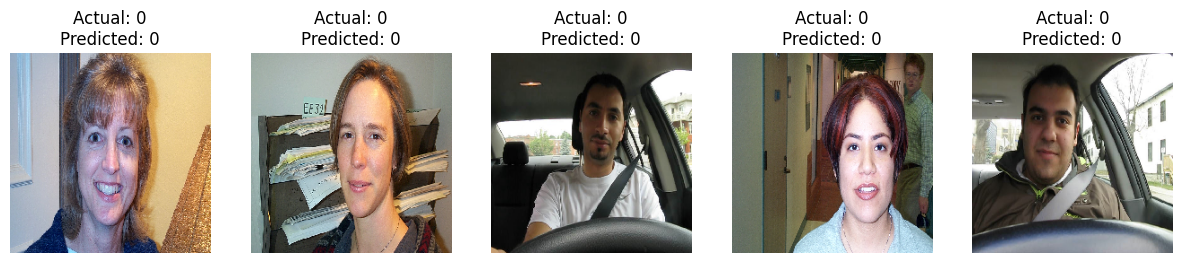

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))

for i in range(num_test_samples):
    plt.subplot(1, num_test_samples, i + 1)
    plt.imshow(selected_images[i])
    plt.title(f"Actual: {int(selected_labels[i])}\nPredicted: {predicted_classes[i]}")
    plt.axis('off')

plt.show()